# Análise de dados de tipos de estrela

Neste projeto, iremos a analisar uma base de dados de características de estrelas coletados pela NASA. 
A base está disponível [no Kaggle](https://www.kaggle.com/brsdincer/star-type-classification), começaremos observando o que a base nos fornece de dados, e então testaremos os algoritmos de classificação para achar o que melhor ajuda a prever o tipo de estrela baseado nos demais atributos e por fim mostraremos alguns gráficos baseados nos atributos e como elas se diferem em si.

Primeiramento vamos importar as bibliotecas necessárias e importar os dados:

In [2]:
# discriminante linear e quadrático
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis

# naive bayes, com distribuição gaussiana
from sklearn.naive_bayes import GaussianNB

# faz uma transformação de escala nos atributos, para que tenham média zero e desvio padrão 1
from sklearn.preprocessing import StandardScaler

# carregamento de dados artificiais do sitem OpenML
from sklearn.datasets import make_moons, make_circles, fetch_openml

from sklearn.metrics import f1_score, roc_auc_score, cohen_kappa_score, make_scorer, confusion_matrix, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.metrics.scorer import roc_auc_scorer, accuracy_scorer

#Avaliação cruzada
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold

import matplotlib.pyplot as plt
from matplotlib import colors

import numpy as np
import pandas as pd
from collections import Counter

/home/vitorguilhermeantunes/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
#buscando os dados
data = pd.read_csv('Stars.csv')

A seguir temos os dados um resumo dos primeiros dados da base:

In [4]:
data.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0


Agora vamos ver rapidamente os dados categoricos, começando pelas cores das estrelas:

In [5]:
print(pd.unique(data["Color"]))

['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'yellowish' 'Yellowish' 'Orange-Red'
 'Blue-White']


Sobre a classe espectral, pode se ver o que eles significam [aqui] (https://en.wikipedia.org/wiki/Asteroid_spectral_types)

Abaixo os diferentes tipos espectrais das estrelas da base:

In [6]:
print(pd.unique(data["Spectral_Class"]))

['M' 'B' 'A' 'F' 'O' 'K' 'G']


Apesar da coluna "Type" aparentar ser numérica ela é categórica, pois os códigos (de 0 a 5), ent~ao optamos por criar um objeto para representar os tipos:

In [7]:
nomes_tipos_estrelas = {
    'Red Dwarf': 0,
    'Brown Dwarf': 1,
    'White Dwarf': 2,
    'Main Sequence': 3,
    'Super Giants': 4,
    'Hyper Giants': 5
}

Vamos começar compararando dados categóricos com outros categóricos, comparando o tipo espectral (`Spectral_Class`) com o tipo da estrela (`Type`):

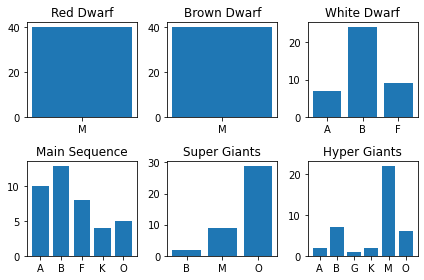

In [34]:
# Aqui vem o código com o plot dos gráficos comparando para cada tipo de estrela (eixo y) como se distribui nos
# espectros (eixo x), ou seja, para cada tipo diferente de estrela ("Type") um gráfico de barra diferente, por 
# exemplo, quantas "Red Dwarf" (zero) temos no espectro 'O', 'M', 'K', 'G' e assim por diante


#Pegando os tipos de estrelas:
tipos_de_estrelas = pd.unique(data['Type'])
espectros = pd.unique(data['Spectral_Class'])


#aqui declaramos o conjunto vazio que vai guardar para cada tipo de estrela 
datasets_tipos_espectros = []
#para cada tipo vamos calcular o qual a frequencia de cada espectro
for tipo in tipos_de_estrelas:
    estrelas_de_um_tipo = data[data.Type == tipo]

    count_espectros = estrelas_de_um_tipo.groupby('Spectral_Class').agg({'Spectral_Class': ['count']})
    
    count_espectros.columns = ['quantidade']
    
    datasets_tipos_espectros.append(count_espectros)

    
figure, axis = plt.subplots(2,3)
i = j = 0

x = espectros

datasets_tipos_espectros[0].head()

for nome, indice in nomes_tipos_estrelas.items():
 
    estrelas = datasets_tipos_espectros[indice]
    
    x = estrelas.index
    y = estrelas['quantidade']
    
    axis[i, j].bar(x, y)
    axis[i, j].set_title(nome)
     
    #print("i: {i}|j:{j}".format({i = i, j = j}))
    j = j + 1
    
    if indice == 2:
        j = 0;
        i = 1;

plt.tight_layout()        
plt.show()
    

Agora vamos ver como é a distribuição da temperatura das estrelas para cada tipo:

In [57]:
#Aqui será um trecho de código que pegamos aquele gráfico de distruição e faremos gráficos para cada tipo de 
# estrela mas dessa vez o tipo será o eixo X, e a temperatura será o eixo Y do gráfico, aí poderíamos tirar 
# também a média, mediana, desvio padrão, etc da temperatura de cada tipo de estrela

Agora fazendo da mesma forma que vimos em aula vamos comparar os algoritmos de classficação e vê qual deles nos serve melhor classificar as estrelas:

In [12]:
#Primeiro precisamos tratar os dados aqui, os atributos categóricos como Spectral_Class e Color devem ser 
# convertidos para valores numéricos (talvez eu não tenho certeza, pode ser também que seja melhor descartá-los 
# para prever o tipo de estrela e considerar somente os atributos núméricos)

In [13]:
# #definindo os classificadores que testaremos 
# classificadores = {
#     'Naive Bayes (Gaussian)' : GaussianNB(),
#     'Discriminante Linear' : LinearDiscriminantAnalysis(),
#     'Discriminante Quadrático' : QuadraticDiscriminantAnalysis()
# }

# #critérios de avaliação
# scoring = {'accuracy': accuracy_scorer,
#            'f1': make_scorer(f1_score, pos_label='2'),
#            'kappa' : make_scorer(cohen_kappa_score),
#            'auc_roc' : roc_auc_scorer
# }


# results = []

# for clf_name, clf in classificadores.items():
#     tmp = cross_validate(clf, data, data["Type"], cv=10, scoring=scoring, return_train_score=True)
#     tmp['clf'] = [clf_name]*10
#     tmp['fold'] = range(10)

#     results.append(pd.DataFrame(tmp))

# results = pd.concat(results)
# results.rename(columns={'fit_time' : 'train_time' , 'score_time' : 'test_time'}, inplace=True)